<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka_6v_all_testonall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [33]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [34]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']]
###  xs = sig[i][['MTtot',  'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']] #.head(len(xs))
###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(len(xs))
  xbw= bckg[i][['weight']] #.head(len(xs))
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])

  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  xsw = xsw.mul(sum_bw/sum_sw)

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1414396, 6) (1414396, 1) (1414396, 1)
(1425476, 6) (1425476, 1) (1425476, 1)
(1446300, 6) (1446300, 1) (1446300, 1)
(1461095, 6) (1461095, 1) (1461095, 1)
(1471361, 6) (1471361, 1) (1471361, 1)
(1483219, 6) (1483219, 1) (1483219, 1)
(1448090, 6) (1448090, 1) (1448090, 1)
(1447411, 6) (1447411, 1) (1447411, 1)
(1445797, 6) (1445797, 1) (1445797, 1)
(1414950, 6) (1414950, 1) (1414950, 1)
(1395065, 6) (1395065, 1) (1395065, 1)
(1384146, 6) (1384146, 1) (1384146, 1)
(1375814, 6) (1375814, 1) (1375814, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [35]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=0.99, shuffle=True, random_state=42)



(18613120, 6) (18613120, 1) (18613120, 1)


In [36]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [37]:
# prepare keras model

def define_model():
  n_nodes = 256 #16 #128
  dropout = 0.01
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=(6,)))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [38]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")

  '''
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False)
  '''  
  def lr_schedule(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        #return lr * pow(decay_rate, np.floor(epoch / decay_step))
        return lr * decay_rate
    return lr
  
  optimizer = tf.keras.optimizers.Adam() #learning_rate=lr_schedule)

  def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
  lr_metric = get_lr_metric(optimizer) 

  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'  'binary_crossentropy'
              optimizer=optimizer, #"sgd",
              metrics=[tf.keras.metrics.AUC(name='auc'),lr_metric])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1
  )

  callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

  epochs = 100
  batch_size=128
  print("fitting")
  history = model.fit(x_train, y_train, 
                    sample_weight=sw_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val, sw_val),
                    callbacks=[es,callback])




  return history, model
#sample_weight = sw_train,

K-folding

In [39]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    loss, auc, _  = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
		# stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    #save model
    aux = '/content/drive/MyDrive/jkrzysiak/model'+str(len(models)-1)+'.h5'
    model.save(aux)

    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [40]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [41]:
def network_fit(x_train_all, y_train_all, sw_train_all):


  #convert to numpy

  np_x_train_all = x_train_all.to_numpy()
  np_y_train_all = y_train_all.to_numpy()
  np_sw_train_all = sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 2  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [42]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
71981/71981 [==============================] - 1239s 17ms/step - loss: 0.0746 - auc: 0.6855 - lr: 9.9982e-04 - val_loss: 0.0597 - val_auc: 0.5338 - val_lr: 9.9961e-04
Epoch 2/100
71981/71981 [==============================] - 398s 6ms/step - loss: 0.1825 - auc: 0.6599 - lr: 8.5023e-04 - val_loss: 0.0631 - val_auc: 0.7162 - val_lr: 8.5048e-04
Epoch 3/100
71981/71981 [==============================] - 394s 5ms/step - loss: 0.1106 - auc: 0.6932 - lr: 7.2253e-04 - val_loss: 0.0580 - val_auc: 0.7476 - val_lr: 7.2208e-04
Epoch 4/100
71981/71981 [==============================] - 392s 5ms/step - loss: 0.0921 - auc: 0.7166 - lr: 6.1416e-04 - val_loss: 0.0705 - val_auc: 0.7718 - val_lr: 6.1417e-04
Epoch 5/100
71981/71981 [==============================] - 395s 5ms/step - loss: 0.2058 - auc: 0.7639 - lr: 5.2206e-04 - val_loss: 0.0913 - val_auc: 0.7792 - val_lr: 5.2229e-04
Epoch 6/100
71981/71981 [==============================] - 396s 5ms/step - loss: 0.11

Make plots

dict_keys(['loss', 'auc', 'lr', 'val_loss', 'val_auc', 'val_lr'])


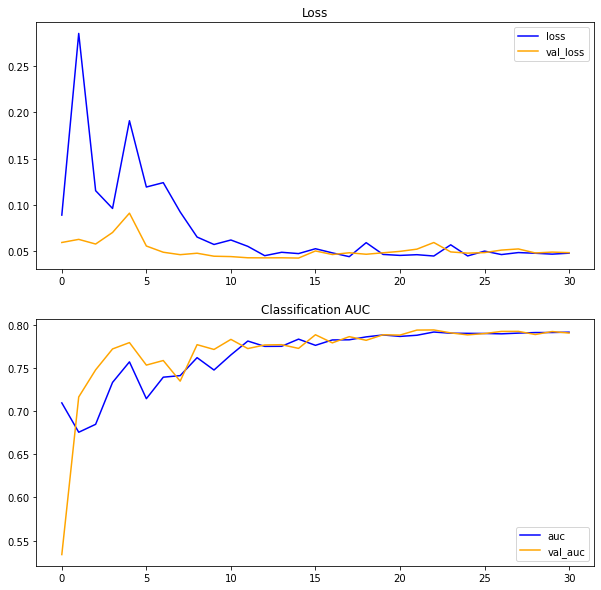

Accuracy: mean=1182.041 std=0.000, n=1


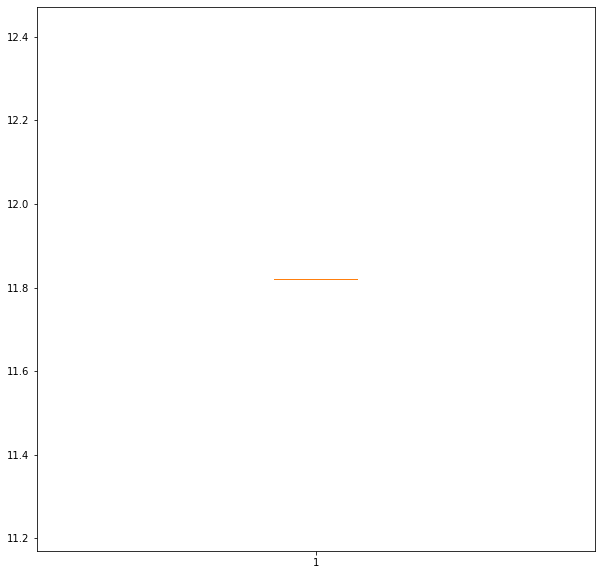

Scores:  [11.820405006408691]


In [43]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Calculate AUC

In [44]:
def getAuc(x, y):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    This is a general function, given points on a curve.  For computing the
    area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
    way to summarize a precision-recall curve, see
    :func:`average_precision_score`.
    Parameters
    ----------
    x : ndarray of shape (n,)
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    y : ndarray of shape, (n,)
        y coordinates.
    Returns
    -------
    auc : float
    See Also
    --------
    roc_auc_score : Compute the area under the ROC curve.
    average_precision_score : Compute average precision from prediction scores.
    precision_recall_curve : Compute precision-recall pairs for different
        probability thresholds.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    >>> metrics.auc(fpr, tpr)
    0.75
    """
    from sklearn.utils import check_consistent_length
    from sklearn.utils import column_or_1d, check_array


    check_consistent_length(x, y)
    x = column_or_1d(x)
    y = column_or_1d(y)

    if x.shape[0] < 2:
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % x.shape)

    direction = 1
    dx = np.diff(x)

    if np.count_nonzero(dx>=0) < np.count_nonzero(dx<=0):
      direction = -1

    # remove elements with diff<=0 
    x=np.delete(x,np.nonzero(direction*dx <= 0))
    y=np.delete(y,np.nonzero(direction*dx <= 0))
    dx=np.delete(dx,np.nonzero(direction*dx <= 0))  
    #print("dx<0 indices are ", np.nonzero(dx <= 0),np.array((np.nonzero(dx <= 0))).shape,dx[dx<=0]) 

    area = direction * np.trapz(y, x)
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in np.trapz do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area

Build an ensamble of networks trained using k-folding and test it on test data

---



In [45]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #Limit the number of events
  #n_events = 100000
  #x_test_all, y_test_all, sw_test_all = x_test_all[0:n_events], y_test_all[0:n_events], sw_test_all[0:n_events]


  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()



  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  # replace negative values by zero
  #summed[summed<0] = 0
  #summed_s[summed_s<0] = 0
  #summed_b[summed_b<0] = 0
  
  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all, drop_intermediate=False)
  print("Number of ROC thresholds: ", tresholds.shape)
  r_auc = getAuc(fpr,tpr)
  print('auc = ',r_auc)


  #m = tf.keras.metrics.AUC(num_thresholds=1000)
  #m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  #r_auc = m.result().numpy()
  #print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    #m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    #aucs.append(m.result().numpy())
    fpr, tpr, tresholds = roc_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all, drop_intermediate=False)
    aucs.append(getAuc(fpr,tpr))


  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr,tpr)
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))
  summed_s = summed_s.reshape((len(summed_s),1))
  summed_b = summed_b.reshape((len(summed_b),1))

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=False, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=False, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Test accuracy

In [46]:
def accuracy_ensamble(x_test_all, y_test_all, sw_test_all):

  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  #np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  #np_y_test_all = y_test_all.to_numpy()
  #np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()

  np_sw_test_all_s = np_sw_test_all_s.reshape((len(np_sw_test_all_s)))
  np_sw_test_all_b = np_sw_test_all_b.reshape((len(np_sw_test_all_b)))

  # normalize test data
  #np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  #yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  #summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  cut=0.5
  summed_s[summed_s>cut] = 1
  summed_s[summed_s<cut] = 0
  summed_b[summed_b>cut] = 1
  summed_b[summed_b<cut] = 0

  isummed_s = summed_s.astype(np.int32)
  isummed_b = summed_b.astype(np.int32)


  false_neg, true_pos = np.bincount(isummed_s, weights=np_sw_test_all_s)
  #false_neg=np.bincount((1-isummed_s), weights=np_sw_test_all_s)
  true_neg, false_pos = np.bincount(isummed_b, weights=np_sw_test_all_b)
  #false_pos=np.bincount((1-isummed_b), weights=np_sw_test_all_b)

  #print("true_pos = ",true_pos)
  #print("false_neg = ",false_neg)
  #print("true_neg = ",true_neg)
  print("false_pos = ",false_pos)

  sensitivity = true_pos / (true_pos+false_neg)
  specificity = true_neg / (true_neg+false_pos)
  accuracy    = (true_pos + true_neg)/(true_pos + true_neg + false_neg + false_pos)

  print("accuracy = ",accuracy,", specificity = ", specificity,", sensitivity = ", sensitivity)

  return accuracy, specificity, sensitivity

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
Number of ROC thresholds:  (526905,)
auc =  0.9632254804344458


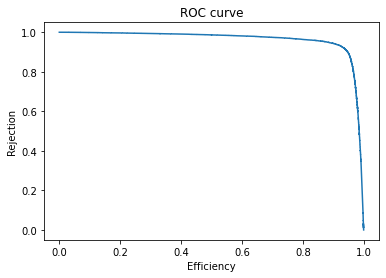

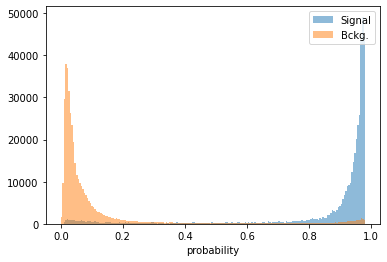

false_pos =  25244.224424485707
accuracy =  0.9272167274792555 , specificity =  0.9372280980359473 , sensitivity =  0.9172144113332915
-------------------------------------------
signal_mass =  250
Number of ROC thresholds:  (594442,)
auc =  0.97894801304671


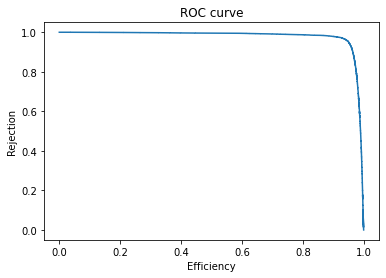

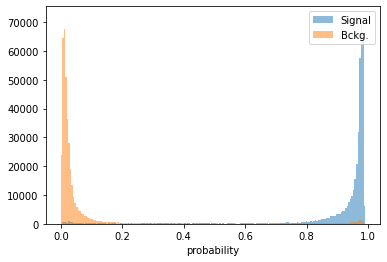

false_pos =  22347.514022969048
accuracy =  0.9515600066301237 , specificity =  0.9444380819664052 , sensitivity =  0.9586856819298816
-------------------------------------------
signal_mass =  300
Number of ROC thresholds:  (637640,)
auc =  0.9862064429884904


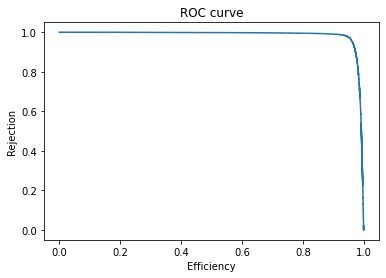

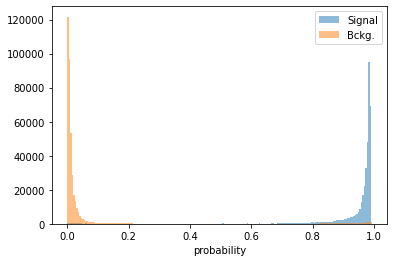

false_pos =  19993.746987515493
accuracy =  0.9628628976218238 , specificity =  0.9502906290617729 , sensitivity =  0.9754531655214518
-------------------------------------------
signal_mass =  350
Number of ROC thresholds:  (657781,)
auc =  0.9896614905433597


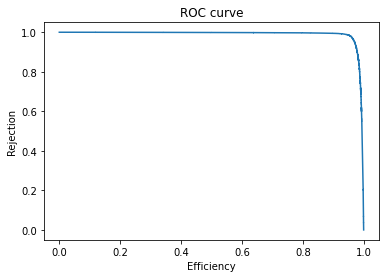

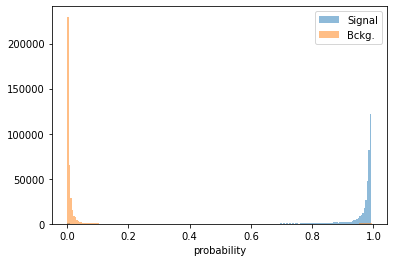

false_pos =  17568.34506534007
accuracy =  0.9686175130442881 , specificity =  0.9563025416805221 , sensitivity =  0.980935521364284
-------------------------------------------
signal_mass =  400
Number of ROC thresholds:  (673636,)
auc =  0.9925528984333549


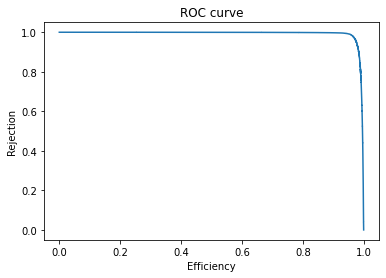

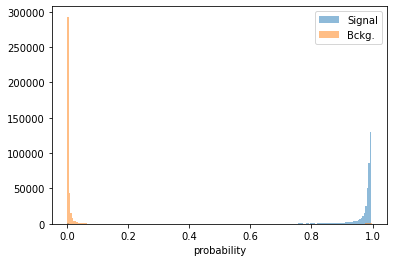

false_pos =  15628.954487566021
accuracy =  0.9726543545977023 , specificity =  0.9611467182688364 , sensitivity =  0.9841555700068917
-------------------------------------------
signal_mass =  500
Number of ROC thresholds:  (682123,)
auc =  0.9954895376560191


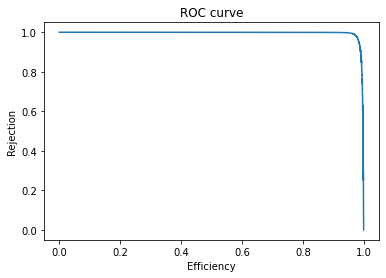

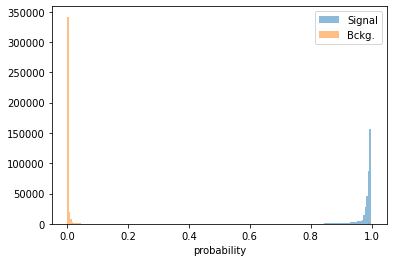

false_pos =  12233.41496984229
accuracy =  0.9792763435144524 , specificity =  0.9695764319590414 , sensitivity =  0.9889801553952732
-------------------------------------------
signal_mass =  600
Number of ROC thresholds:  (628518,)
auc =  0.9970049244618208


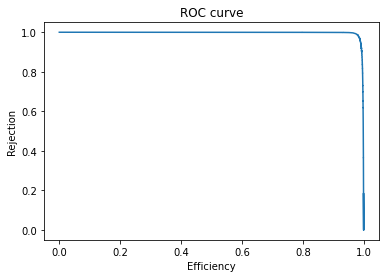

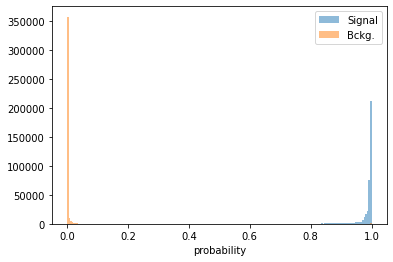

false_pos =  9370.974791545761
accuracy =  0.9834346557086964 , specificity =  0.9766867585663317 , sensitivity =  0.9901840628182463
-------------------------------------------
signal_mass =  700
Number of ROC thresholds:  (588599,)
auc =  0.9977872828603945


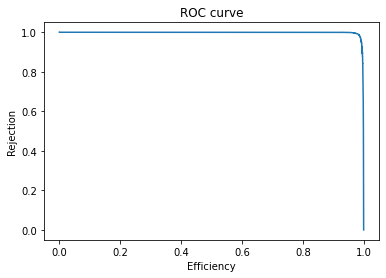

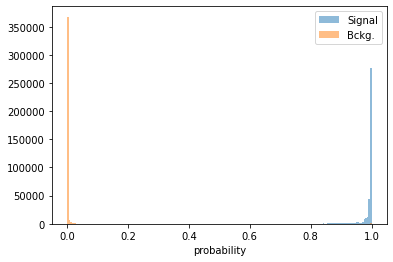

false_pos =  7372.662763122898
accuracy =  0.9857802044284597 , specificity =  0.9816658253775385 , sensitivity =  0.9898968172900615
-------------------------------------------
signal_mass =  800
Number of ROC thresholds:  (551407,)
auc =  0.9984731258975048


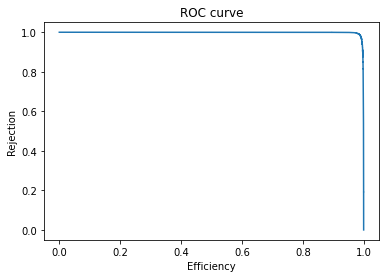

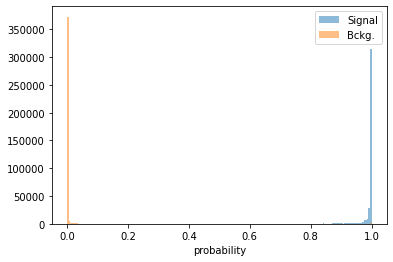

false_pos =  5800.024758819269
accuracy =  0.9874025595214767 , specificity =  0.9855755158406599 , sensitivity =  0.9892303944741341
-------------------------------------------
signal_mass =  1200
Number of ROC thresholds:  (541457,)
auc =  0.9993258878970073


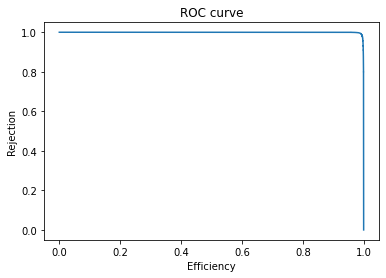

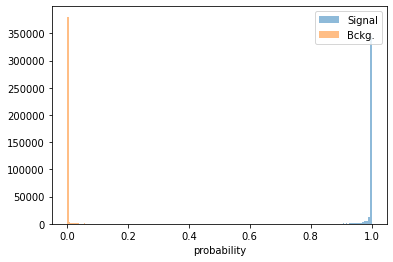

false_pos =  3659.5355824312214
accuracy =  0.9920554282319418 , specificity =  0.9908976045263689 , sensitivity =  0.9932130417614624
-------------------------------------------
signal_mass =  1500
Number of ROC thresholds:  (562673,)
auc =  0.9997256751647572


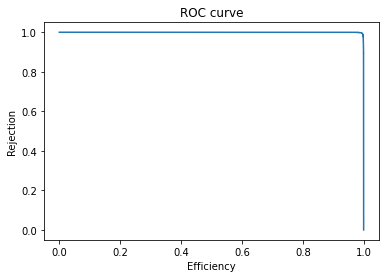

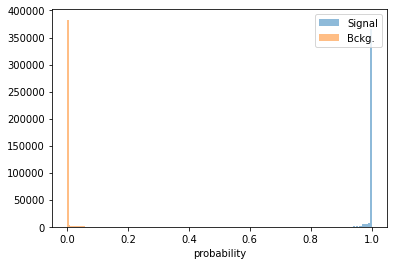

false_pos =  2492.3906916896913
accuracy =  0.9947718341922153 , specificity =  0.9938050921599278 , sensitivity =  0.9957374318353908
-------------------------------------------
signal_mass =  2000
Number of ROC thresholds:  (584264,)
auc =  0.9997806505247571


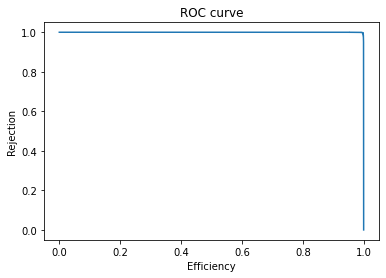

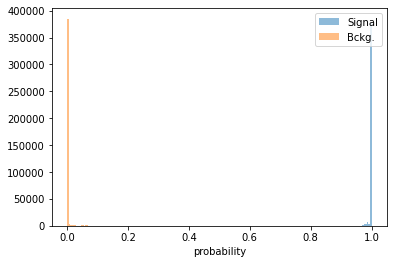

false_pos =  1367.40061527213
accuracy =  0.9969198398535082 , specificity =  0.9966004346489014 , sensitivity =  0.9972395080701781
-------------------------------------------
signal_mass =  2500
Number of ROC thresholds:  (618590,)
auc =  0.9999397100551377


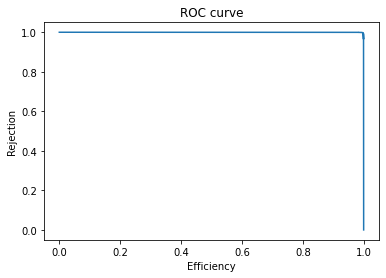

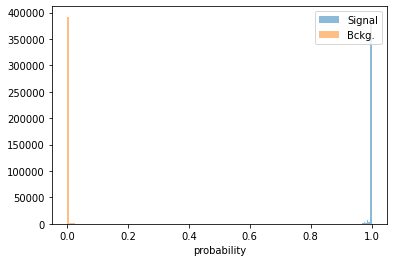

false_pos =  797.6790408432919
accuracy =  0.9976133897744482 , specificity =  0.9980164675884864 , sensitivity =  0.9972096991182233
-------------------------------------------


In [47]:
auc_list = []
av_auc_list = []
aucs_list = []

acc_list = []
spec_list = []
sens_list = []

for m in masses:
  print("signal_mass = ",m)
  #mask = np.in1d(x_test_all.signal_mass, m)
  mask = np.in1d(x_train_all.signal_mass, m)

  #x_test_m = x_test_all[mask]
  #y_test_m = y_test_all[mask]
  #sw_test_m = sw_test_all[mask]

  x_test_m = x_train_all[mask]
  y_test_m = y_train_all[mask]
  sw_test_m = sw_train_all[mask]

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

  accuracy, specificity, sensitivity = accuracy_ensamble(x_test_m, y_test_m, sw_test_m)
  acc_list.append(accuracy)
  spec_list.append(specificity)
  sens_list.append(sensitivity)
  
  print("-------------------------------------------")


Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

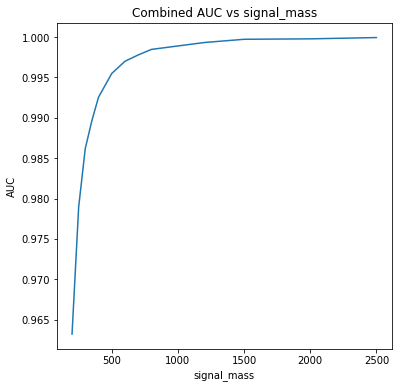

[0.9632254804344458]


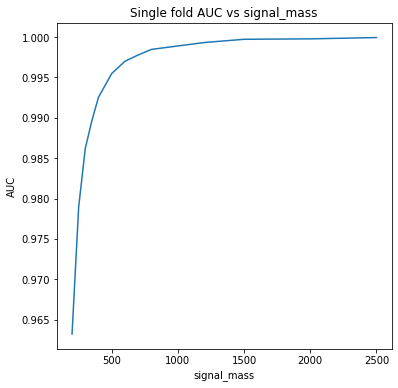

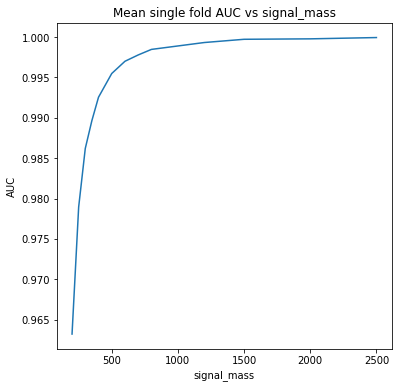

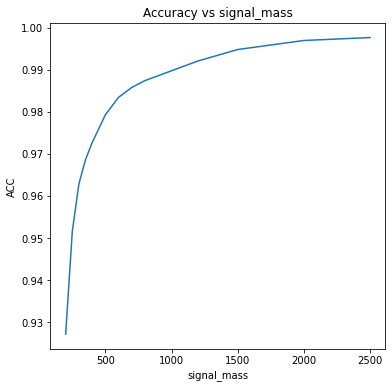

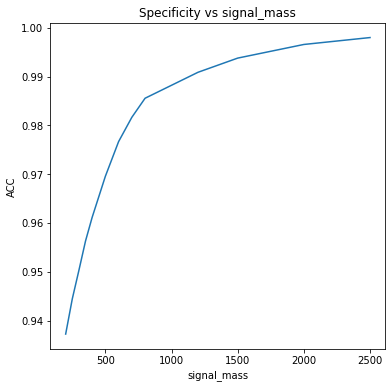

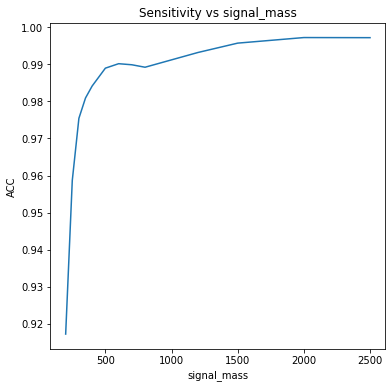

,signal_mass,comb. auc,mean auc,acc,specificity,sensitivity
0,200,0.963225,0.963225,0.927217,0.937228,0.917214
1,250,0.978948,0.978948,0.951560,0.944438,0.958686
2,300,0.986206,0.986206,0.962863,0.950291,0.975453
3,350,0.989661,0.989661,0.968618,0.956303,0.980936
4,400,0.992553,0.992553,0.972654,0.961147,0.984156
5,500,0.995490,0.995490,0.979276,0.969576,0.988980
6,600,0.997005,0.997005,0.983435,0.976687,0.990184
7,700,0.997787,0.997787,0.985780,0.981666,0.989897
8,800,0.998473,0.998473,0.987403,0.985576,0.989230
9,1200,0.999326,0.999326,0.992055,0.990898,0.993213


In [48]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(acc_list))
plt.title('Accuracy vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(spec_list))
plt.title('Specificity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(sens_list))
plt.title('Sensitivity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list, acc_list, spec_list, sens_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc', 'acc', 'specificity', 'sensitivity']) 
aucf

Stop program execution

In [49]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

In [ ]:
auc_list_sep = []

for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[1].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc_list_sep.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep)), 
               columns =['signal_mass', 'auc']) 
aucf